In [1]:
wd <- dirname(dirname(getwd()))

source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/exhaustive_settings.R"))
source(paste0(wd,"/mission_control/helpers/figures/exhaustive_plots.R"))

library(tidyverse)
library(ggrepel)
library(RColorBrewer)
library(gridExtra)
library(survminer)
library(ggpubr)
library(geneLenDataBase)
data(hg19.geneSymbol.LENGTH)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.1
Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘purrr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”Warning message:
“package ‘forcats’ was built under R version 3.6.3”── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is 

#### Put in settings

In [2]:
o_dir <- paste0("/workspace/projects/immune_biomarkers/figures/supplement/exhaustive/")

theme_go <- (
    theme_classic(base_size = 20) + 
    theme(
            plot.margin = unit(c(0,0,0,0), "cm"), 
            plot.title = element_text(hjust = 0.5, size = 18),
            legend.position="none"
     ) 
)

legend_theme <- theme(legend.position = "right", legend.text = element_text(size=20),
                               legend.background = element_rect(colour = 'black', 
                                                                fill = 'white', 
                                                                linetype='solid'))

### 0 - Take out prepared datasets

In [3]:
ingredients <- readRDS(paste0(TMP_DIR,"exhaustive-plots-base.Rds")) %>% filter(covariates == "none")

#### Get Gene sizes

In [4]:
ref_length <- hg19.geneSymbol.LENGTH %>% group_by(Gene) %>% summarise(Length = max(Length)) %>% ungroup()
s1 <- ingredients %>% filter( feature_group == "somatic.gene", dataset == "all", model == "bor")
s1$Gene <- unlist(lapply( s1$feature, function(i) strsplit(strsplit( i, "_")[[1]][2], ".mb")[[1]][1]))

In [5]:
s2 <- (
    s1 
        %>% left_join( ref_length, by = "Gene") 
        %>% arrange(desc(Length))
        %>% drop_na(Length)
)
s2$len_gp <- cut(as.numeric(log(s2$Length)), breaks = c(0, 7.1, 8.76, 10000), labels = c("Small", "Medium", "Big")) #cut(s2$Len
s2$lg_len <- log(s2$Length)
s2$est_gp <- ifelse( s2$est > 0 , "Positive", "Negative")
s2$Association_with_Response <- factor(ifelse( s2$est > 0 , "Positive", "Negative"), levels = c("Positive", "Negative"))
s2$Somatic_Gene_Mutations <- "Gene Mutations"

### Make plots

In [6]:
p1 <- (
    ggplot( s2, aes( x = cor_tmb, y = log10_p, shape = est_gp) ) +
    geom_point(fill = '#80B1D3', alpha = .8, size = 3) + geom_smooth(span = 0.3, aes( x = cor_tmb, y = log10_p), color = "red", data=subset(s2,est > 0 )) + 
    scale_color_manual(values = c("grey", "white")) + 
    scale_shape_manual(values = c(25, 24)) + 
    labs(x = "Correlation with Log(TMB)", y = "-Log10 (p-value)", title = "-Log10 (p-value) vs TMB correlation") + 
    theme_go 
    #+ geom_label( data = s2 %>% filter(grepl("BRCA2", feature)), aes( x = cor_tmb, y = log10_p, label = Gene))
)
p2 <- (
    ggplot( s2, aes( x = lg_len, y = cor_tmb) ) +
    geom_point(fill = '#80B1D3', color = "black", alpha = .8, shape = 21, size = 3) + 
    geom_smooth(span = 0.3, aes( x = lg_len, y = cor_tmb), color = "red") + 
    xlim(5,10.5) + 
    labs(x = "Log (Gene Transcript Length)", y = "Correlation with Log (TMB)", title = "TMB correlation vs Gene Length") + 
    theme_go 
    #+ geom_label( data = s2 %>% filter(grepl("BRCA2", feature)), aes( x = lg_len, y = cor_tmb, label = Gene))
)
p3 <- (
    ggplot( s2, aes( x = lg_len, y = log10_p, shape = est_gp) ) +
    geom_point(fill = '#80B1D3', color = "black", alpha = .8, size = 3) + 
    geom_smooth(span = 0.3, aes( x = lg_len, y = log10_p), col = "red", data=subset(s2,est > 0 )) + 
    scale_color_manual(values = c("white", "white")) + 
    scale_shape_manual(values = c(25, 24)) + 
    xlim(5,10.5) + 
    labs(x = "Log (Gene Transcript Length)", y = "-Log10 (p-value)", title = "-Log10 (p-value) vs Gene Length") + 
    theme_go 
    #+ geom_label( data = s2 %>% filter(grepl("BRCA2", feature)), aes( x = lg_len, y = log10_p, label = Gene))
)
p4 <- (
    ggplot( s2, aes( x = as.factor(len_gp), y = log10_p, fill = len_gp) ) + 
    geom_violin(width=.75) +
    geom_boxplot(width=.35, color="black", alpha=.75, fill = "white") +
    labs( y = "-Log10 (p-value)", x = "Gene Size Group", title = "-Log10 (p-value) by Gene Sizes") + 
    theme_go
)
p5 <- (
    ggplot( s2, aes_string( x = "est", y = "log10_p", shape = "Association_with_Response", fill = "len_gp") ) +
    geom_point(fill = '#80B1D3', alpha = .8, size = 3) +# geom_smooth(span = 0.3, aes( x = est, y = log10_p), color = "red") + 
    scale_color_manual(values = c("grey", "white")) + 
    scale_shape_manual(values = c(24, 25)) + 
    labs(x = "Response Odds Ratio Estimate", y = "-Log10 (p-value)", title = "-Log10 (p-value) vs Coefficient Estimates") + 
    theme_go 
    #+ geom_label( data = s2 %>% filter(grepl("BRCA2", feature)), aes( x = est, y = log10_p, label = Gene))
)

### Prep and combine

In [7]:
get_dressed <- function(grob, title, hjust = .4, size = 20, vjust = 1){
    as_ggplot(grob) + ggtitle(title) + theme(plot.title = element_text(hjust = hjust, size = size, vjust = vjust), plot.margin = unit(c(.4,.4,.4,.4), "cm"))
}
clean_up <- function(i, j, k){
    annote(as_ggplot(arrangeGrob(i)), k) + theme(plot.margin = unit(rep(j, 4), "cm"))
}
annote <- function( i, lab, size = 18 ) annotate_figure( i, fig.lab = lab, fig.lab.size = size, fig.lab.face = "bold")

In [8]:
a <- clean_up( p5, .5, "A")
b <- clean_up( p1, .5, "B")
c <- clean_up( p2, .5, "C")
d <- clean_up( p3, .5, "D")
e <- clean_up( p4, .5, "E")
f <- get_legend(p5 + legend_theme)

together <- arrangeGrob(a, b, c, d, e, f, layout_matrix = rbind(c(1,2,6),c(3,4,5)))
ready <- get_dressed(together, title = "Somatic Gene Mutations: BOR un-adjusted analyses", size = 25)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 2 rows containing missing values (geom_point).”`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

### Send them

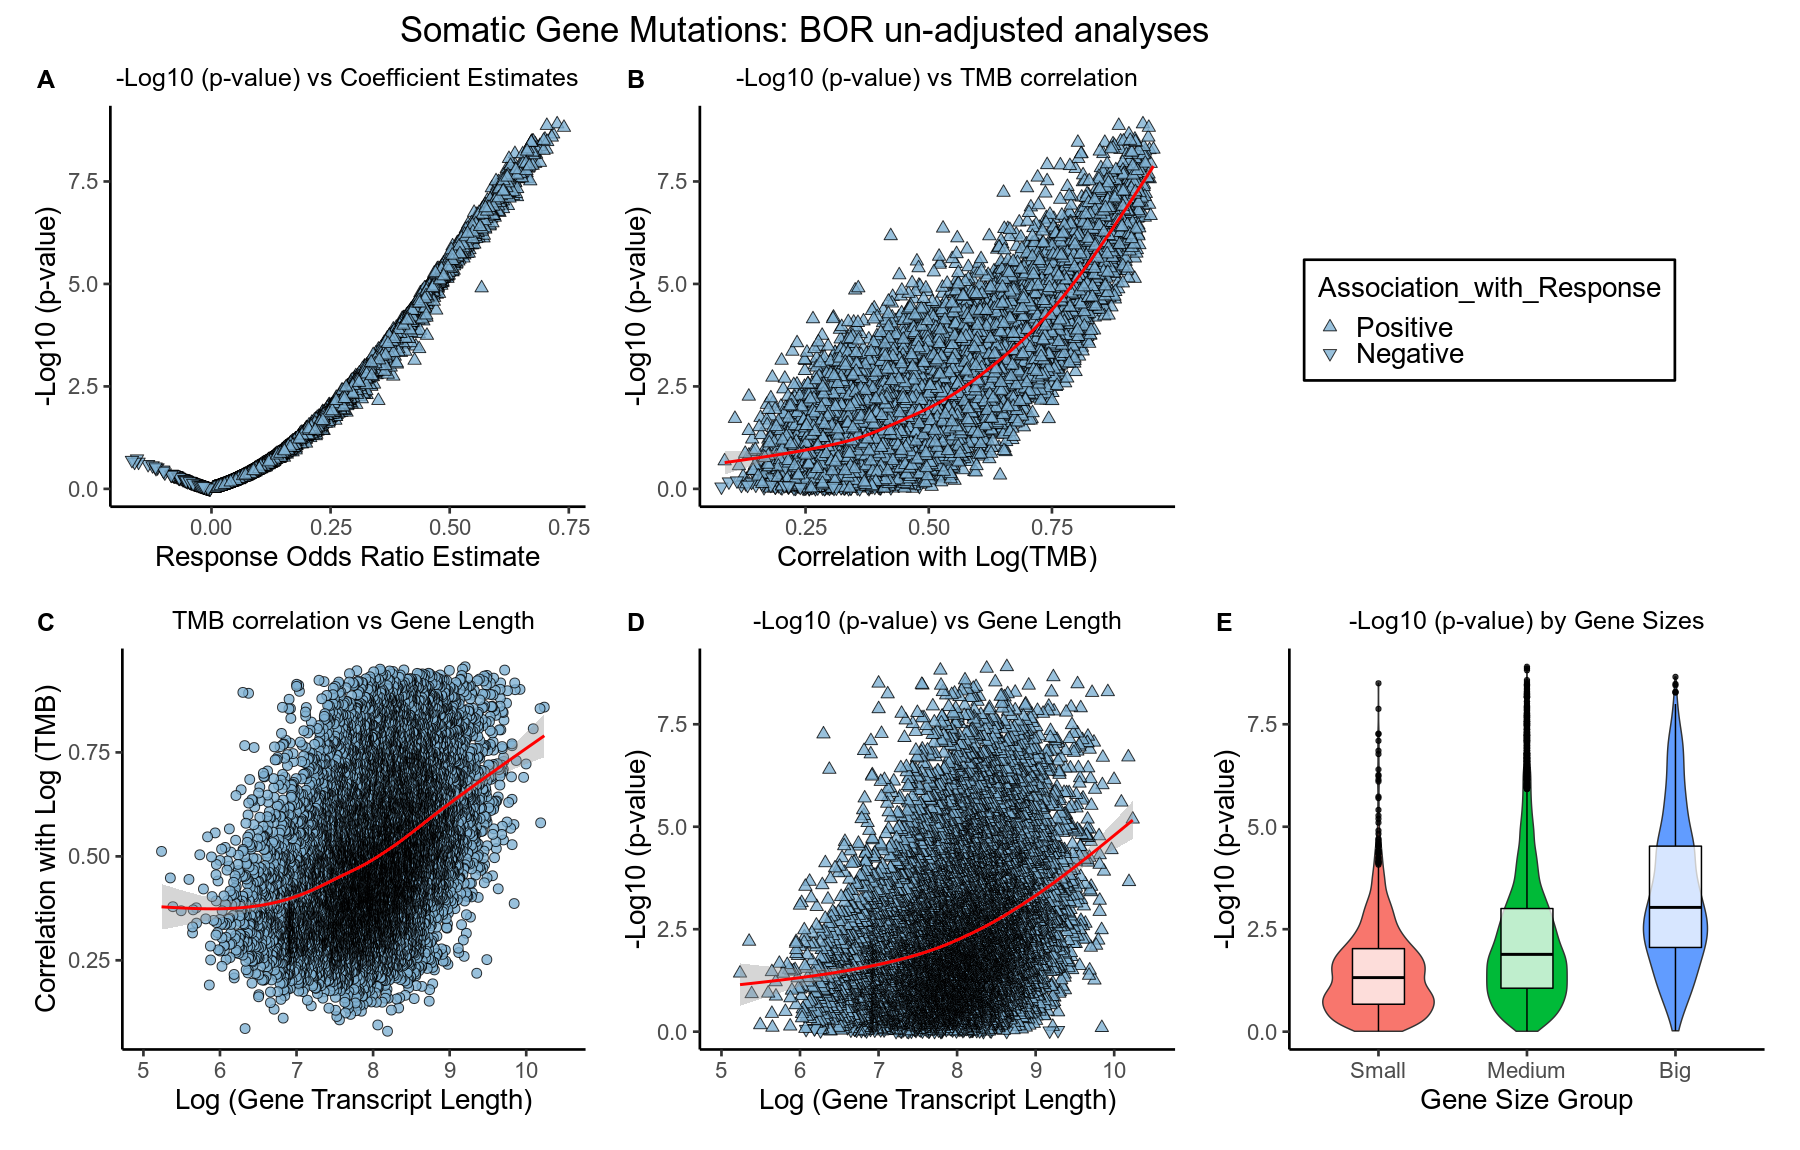

In [10]:
options(repr.plot.width = 18, repr.plot.height = 11.5, repr.plot.res = 100)
plot(ready)
ggsave( paste0(FIG_FINAL_DIR, "1_supplement_somatic_gene.png"), ready, width = 18, height = 11.5)